In [1]:
import numpy as np
import tensorflow as tf

In [2]:
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

In [3]:
class Config(object):
    """
    define a class to store parameters,
    the input should be feature mat of training and testing
    Note: it would be more interesting to use a HyperOpt search space:
    https://github.com/hyperopt/hyperopt
    """

    def __init__(self, X_train, X_test):
        # Input data
        self.train_count = len(X_train)  # 7352 training series
        self.test_data_count = len(X_test)  # 2947 testing series
        self.n_steps = len(X_train[0])  # 128 time_steps per series

        # Training
        self.learning_rate = 0.0025
        self.lambda_loss_amount = 0.0015
        self.training_epochs = 300
        self.batch_size = 1500

        # LSTM structure
        self.n_inputs = len(X_train[0][0])  # Features count is of 9: 3 * 3D sensors features over time
        self.n_hidden = 32  # nb of neurons inside the neural network
        self.n_classes = 6  # Final output classes
        self.W = {
            'hidden': tf.Variable(tf.random_normal([self.n_inputs, self.n_hidden])),
            'output': tf.Variable(tf.random_normal([self.n_hidden, self.n_classes]))
        }
        self.biases = {
            'hidden': tf.Variable(tf.random_normal([self.n_hidden], mean=1.0)),
            'output': tf.Variable(tf.random_normal([self.n_classes]))
        }

In [4]:
def LSTM_Network(_X, config):
    """Function returns a TensorFlow RNN with two stacked LSTM cells
    Two LSTM cells are stacked which adds deepness to the neural network.
    Note, some code of this notebook is inspired from an slightly different
    RNN architecture used on another dataset, some of the credits goes to
    "aymericdamien".
    Args:
        _X:     ndarray feature matrix, shape: [batch_size, time_steps, n_inputs]
        config: Config for the neural network.
    Returns:
        This is a description of what is returned.
    Raises:
        KeyError: Raises an exception.
      Args:
        feature_mat: ndarray fature matrix, shape=[batch_size,time_steps,n_inputs]
        config: class containing config of network
      return:
              : matrix  output shape [batch_size,n_classes]
    """
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, config.n_inputs])
    # new shape: (n_steps*batch_size, n_input)

    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, config.W['hidden']) + config.biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, config.n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, config.W['output']) + config.biases['output']


In [8]:
%matplotlib inline
import pandas as pd
if __name__ == "__main__":
    # -----------------------------
    # Step 1: load and prepare data
    # -----------------------------

    # Those are separate normalised input features for the neural network
    INPUT_SIGNAL_TYPES = [
        "body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_",
        "total_acc_x_",
        "total_acc_y_",
        "total_acc_z_"
    ]

    # Output classes to learn how to classify
    LABELS = [
        "WALKING",
        "WALKING_UPSTAIRS",
        "WALKING_DOWNSTAIRS",
        "SITTING",
        "STANDING",
        "LAYING"
    ]

    DATA_PATH = ""
    DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
    print("\n" + "Dataset is now located at: " + DATASET_PATH)
    TRAIN = "train/"
    TEST = "test/"

    X_train_signals_paths = [
        DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
    ]
    X_test_signals_paths = [
        DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
    ]
    testdata=['sit1.txt','sit2.txt','sit3.txt','stand1.txt','stand2.txt','stand3.txt']
    X_train = load_X(X_train_signals_paths)
    k=0.0
    for i in range(128-128//5):
        k=k+0.2
        X_train=np.delete(X_train,int(k),axis=1)
    X_train=np.delete(X_train,(6,7,8),axis=2)
    print(np.shape(X_train))
    
    #X_test = load_X(X_test_signals_paths)
    #print(X_train[0])
    
    
    
    #X_test=np.delete(X_test,(0,1,2),axis=2)
    testpath='data_new_2912/'
    X_test=pd.read_csv(testpath+"sit1.csv",names=["body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_",'sa','12'])
    #np.delete(X_test,6)
    #X_test=np.array(X_test)
    X_test=X_test.drop(X_test.columns[[6,7]], axis=1)
    X_test=X_test.drop(X_test.index[[875,876,877,878]])
    print(X_test.shape)
    X_test=X_test.values
    print(X_test[24])
    X_test=np.reshape(X_test,((35,25,6)))
    print(X_test[0])
    print(X_test.shape)
    '''X_test=pd.read_csv(testpath+"sit2.csv",names=["body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_",'sa','12'])
    print(X_test.shape)
    #np.delete(X_test,6)
    #X_test=np.array(X_test)
    X_test=X_test.drop(X_test.columns[[6,7]], axis=1)
    X_test=X_test.drop(X_test.index[[625,626,627,628,629,630]])
    print(X_test.shape)
    X_test=X_test.values
    X_test=np.reshape(X_test,((25,25,6)))
    print(X_test.shape)'''
    
    
    
    
    y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
    #y_test_path = DATASET_PATH + TEST + "y_test.txt"
    y_train = one_hot(load_y(y_train_path))
    #y_test = one_hot(load_y(y_test_path))
    y_test=np.zeros((35,6))
    y_test[:,4]=1
    print(y_test)
    
    
    config = Config(X_train, X_test)
    print("Some useful info to get an insight on dataset's shape and normalisation:")
    print("features shape, labels shape, each features mean, each features standard deviation")
    print(X_test.shape, y_test.shape,
          np.mean(X_test), np.std(X_test))
    print("the dataset is therefore properly normalised, as expected.")


Dataset is now located at: UCI HAR Dataset/
(7352, 25, 6)
(875, 6)
[-0.3909215   0.6437743  -0.03510151  0.04559934  0.6319096  -0.2857544 ]
[[  1.17733300e-01   2.77377800e-02   3.00868200e-02  -7.39096000e-03
   -1.23147600e-02   2.40465000e-02]
 [  3.56921100e-01  -6.53331100e-02   1.81200600e-01  -8.18812800e-02
    9.28386700e-02   5.23578000e-02]
 [  9.73180000e-01   3.58738500e-01  -2.96835000e-02  -2.20969500e-01
    6.52620200e-01   3.86742000e-02]
 [  5.44997900e-01  -2.01110300e-03  -3.89643300e-04  -2.27229900e-01
    1.45090200e+00  -1.89259800e-02]
 [ -1.66387500e-01  -2.52928000e-01   1.97789000e-01  -1.63690800e-01
    1.75868300e+00   7.38319000e-02]
 [ -7.72060000e-01   8.58477500e-02  -2.29707400e-01  -1.23769800e-01
    1.04568600e+00   1.10587000e-01]
 [  1.34241700e-01   5.72452400e-02   1.79506200e-01  -1.98581600e-02
    6.02074800e-01   1.38996300e-01]
 [  2.11206600e-01   4.53148800e-01   4.08803000e-01  -7.79590600e-03
    8.50906400e-01   1.04419200e-01]
 [

In [6]:
    X = tf.placeholder(tf.float32, [None, config.n_steps, config.n_inputs])
    Y = tf.placeholder(tf.float32, [None, config.n_classes])

    pred_Y = LSTM_Network(X, config)

    # Loss,optimizer,evaluation
    l2 = config.lambda_loss_amount * \
        sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    # Softmax loss and L2
    cost = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=pred_Y)) + l2
    optimizer = tf.train.AdamOptimizer(
        learning_rate=config.learning_rate).minimize(cost)

    correct_pred = tf.equal(tf.argmax(pred_Y, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [7]:
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
    init = tf.global_variables_initializer()
    sess.run(init)
    y_pre=y_test[0]
    best_accuracy = 0.0
    # Start training for each batch and loop epochs
    for i in range(config.training_epochs):
        for start, end in zip(range(0, config.train_count, config.batch_size),
                              range(config.batch_size, config.train_count + 1, config.batch_size)):
            sess.run(optimizer, feed_dict={X: X_train[start:end],
                                           Y: y_train[start:end]})

        # Test completely at every epoch: calculate accuracy
        pred_out, accuracy_out, loss_out = sess.run(
            [pred_Y, accuracy, cost],
            feed_dict={
                X: X_test,
                Y: y_test
            }
        )
        print("traing iter: {},".format(i) +
              " test accuracy : {},".format(accuracy_out) +
              " loss : {}".format(loss_out))
        if accuracy_out>best_accuracy:
            y_pre=pred_out

    print("")
    print("final test accuracy: {}".format(accuracy_out))
    print("best epoch's test accuracy: {}".format(best_accuracy))
    print("")   
    best_accuracy = max(best_accuracy, accuracy_out)


traing iter: 0, test accuracy : 0.4571428596973419, loss : 1.9989497661590576
traing iter: 1, test accuracy : 0.02857142873108387, loss : 2.281069040298462
traing iter: 2, test accuracy : 0.02857142873108387, loss : 2.305429697036743
traing iter: 3, test accuracy : 0.02857142873108387, loss : 2.546128511428833
traing iter: 4, test accuracy : 0.0, loss : 3.471855640411377
traing iter: 5, test accuracy : 0.08571428805589676, loss : 4.492760181427002
traing iter: 6, test accuracy : 0.05714285746216774, loss : 5.664357662200928
traing iter: 7, test accuracy : 0.0, loss : 6.528818607330322
traing iter: 8, test accuracy : 0.05714285746216774, loss : 6.753074645996094
traing iter: 9, test accuracy : 0.0, loss : 7.258989334106445
traing iter: 10, test accuracy : 0.0, loss : 7.433203220367432
traing iter: 11, test accuracy : 0.0, loss : 7.50606107711792
traing iter: 12, test accuracy : 0.0, loss : 7.61952543258667
traing iter: 13, test accuracy : 0.0, loss : 7.924055099487305
traing iter: 14, t

traing iter: 128, test accuracy : 0.0, loss : 8.374369621276855
traing iter: 129, test accuracy : 0.0, loss : 8.191486358642578
traing iter: 130, test accuracy : 0.0, loss : 8.445229530334473
traing iter: 131, test accuracy : 0.0, loss : 8.489704132080078
traing iter: 132, test accuracy : 0.0, loss : 8.392037391662598
traing iter: 133, test accuracy : 0.0, loss : 8.6050386428833
traing iter: 134, test accuracy : 0.02857142873108387, loss : 8.45052433013916
traing iter: 135, test accuracy : 0.0, loss : 8.562878608703613
traing iter: 136, test accuracy : 0.0, loss : 8.759860038757324
traing iter: 137, test accuracy : 0.02857142873108387, loss : 8.158563613891602
traing iter: 138, test accuracy : 0.0, loss : 8.602044105529785
traing iter: 139, test accuracy : 0.0, loss : 8.503076553344727
traing iter: 140, test accuracy : 0.0, loss : 8.035380363464355
traing iter: 141, test accuracy : 0.0, loss : 8.581905364990234
traing iter: 142, test accuracy : 0.0, loss : 8.504890441894531
traing iter

traing iter: 254, test accuracy : 0.0, loss : 7.989915370941162
traing iter: 255, test accuracy : 0.0, loss : 8.0504789352417
traing iter: 256, test accuracy : 0.02857142873108387, loss : 8.020362854003906
traing iter: 257, test accuracy : 0.0, loss : 8.517203330993652
traing iter: 258, test accuracy : 0.0, loss : 8.024763107299805
traing iter: 259, test accuracy : 0.0, loss : 8.276910781860352
traing iter: 260, test accuracy : 0.0, loss : 7.91554069519043
traing iter: 261, test accuracy : 0.0, loss : 8.961153984069824
traing iter: 262, test accuracy : 0.02857142873108387, loss : 8.534820556640625
traing iter: 263, test accuracy : 0.0, loss : 8.101201057434082
traing iter: 264, test accuracy : 0.0, loss : 8.211852073669434
traing iter: 265, test accuracy : 0.0, loss : 8.410112380981445
traing iter: 266, test accuracy : 0.0, loss : 7.998043060302734
traing iter: 267, test accuracy : 0.0, loss : 7.9875030517578125
traing iter: 268, test accuracy : 0.0, loss : 7.935380458831787
traing ite

In [8]:
b = np.zeros_like(y_pre)
b[np.arange(len(y_pre)), y_pre.argmax(1)] = 1
y_pre=b
print(y_pre)
from sklearn.metrics import confusion_matrix
for i in range(y_test.shape[1]):
    print("Col {}".format(i))
    print(confusion_matrix(y_test[:,i], y_pre[:,i]))
    print("")

[[ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]]
Col 0
[[34  1]
 [ 0  0]]

Col 1
[[22 13]
 [ 0  0]]

Co

In [9]:
n_classes=6

Testing Accuracy: Tensor("mul_1:0", shape=(), dtype=float32)%

Precision: 100.0%
Recall: 2.857142857142857%
f1_score: 5.555555555555556%

Confusion Matrix:
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 13 19  1  1]
 [ 0  0  0  0  0]]

Confusion matrix (normalised to % of total test data):
[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  2.85714293  37.1428566   54.28571701   2.85714293   2.85714293]
 [  0.           0.           0.           0.           0.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


c:\users\naru_piece\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\naru_piece\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\users\naru_piece\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\naru_piece\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


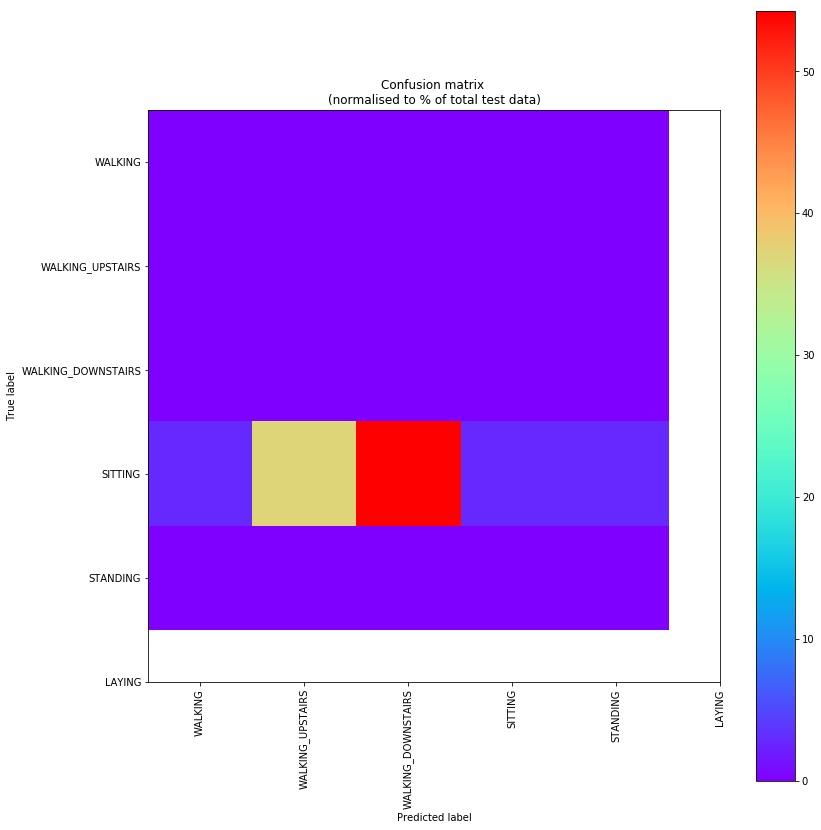

In [10]:
import matplotlib.pyplot as plt
from sklearn import metrics
predictions = y_pre

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
%matplotlib inline
# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()